# Task1 Data Generation
We created a Wechat group of **6 people**, where each person sent **50 WREs**, each containing **50r**, distributed to all 6 people.

That is to say, totally **300 i.i.d. samples from the distribution**.

# Task2 Data Processing
## Raw Data Collecting
We made use of an scripting software **Airtest** to traverse the ChatLog to get **Snapshots of WRE Reception Record Infos**.
## Data Extracting and Processing
We deployed **gemma3** model with **Ollama** on **WSL** and **Dify** with **Docker** on **Windows Host**. Gemma3 is able to **read images**.

Then we built a workflow on **Dify**, which is able to call **gemma3** to extract **Receiver Order Index** and **Receive Amount** from the **Snapshots**, and **structure-output json files** for later processing.

Then we wrote 2 python scripts:
- **DataExtractor.py** : Making use of **Dify's API** to **upload snapshots** and **get the returned jsons**.
- **DataProcessor.py** : 
  - Get input snapshots
  - Call DataExtractor.py in loops
  - Do postprocess
  - Draw and output the plots
### Visualization
- A **Scatter** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
- A **Boxplot** showing how much **receivers with different Receiver Order Index** receives   (*x:index* - *y:amount*)
- 6 **Histograms** showing the distribution of each receiver with different **Receiver Order Index**'s receive amount   (*x:amount* - *y:frequency*)

In [1]:
import requests
import json
import os
import mimetypes
import glob
import numpy as np
import matplotlib.pyplot as plt

## DataExtractor(No Need to Run)

In [ ]:
# ====== Configuration ======
LOCAL_DIFY_URL = "http://localhost"
API_KEY = "app-5Wjz73iI02lHt23TiDULPkIL"
USER_ID = "PositionZero"
# IMAGE_PATH = "./Snapshots/info0.png"
# SAVE_PATH = "./result.json"


def upload_file(file_path, user, base_url, api_key):
    upload_url = f"{base_url}/v1/files/upload"
    headers = {
        "Authorization": f"Bearer {api_key}",
    }

    try:
        # print(f"正在上传图片: {os.path.basename(file_path)}")
        with open(file_path, "rb") as file:
            mime_type, _ = mimetypes.guess_type(file_path)
            if not mime_type:
                mime_type = "application/octet-stream"

            files = {"file": (os.path.basename(file_path), file, mime_type)}
            data = {"user": user}

            response = requests.post(
                upload_url, headers=headers, files=files, data=data, timeout=60
            )
            if response.status_code == 201 or response.status_code == 200:
                # print("✅ 文件上传成功")
                return response.json()
            else:
                print(f"❌ 文件上传失败，状态码: {response.status_code}")
                try:
                    print(response.json())
                except:
                    print(response.text)
                return None
    except Exception as e:
        print(f"❌ 上传发生错误: {str(e)}")
        return None


def run_workflow(file_id, user, base_url, api_key, response_mode="blocking"):
    workflow_url = f"{base_url}/v1/workflows/run"
    headers = {"Authorization": f"Bearer {api_key}", "Content-Type": "application/json"}

    data = {
        "inputs": {
            "RedPacketInfo": {
                "transfer_method": "local_file",
                "upload_file_id": file_id,
                "type": "image",
            }
        },
        "response_mode": response_mode,
        "user": user,
    }

    try:
        # print("正在调用工作流运行接口...")
        response = requests.post(workflow_url, headers=headers, json=data, timeout=120)
        if response.status_code == 200:
            # print("✅ 工作流执行成功")
            return response.json()
        else:
            print(f"❌ 工作流执行失败，状态码: {response.status_code}")
            try:
                print(response.json())
            except:
                print(response.text)
            return {
                "status": "error",
                "message": f"Failed to execute workflow, status code: {response.status_code}",
            }
    except Exception as e:
        print(f"❌ 运行发生错误: {str(e)}")
        return {"status": "error", "message": str(e)}


def extract_data_from_image(
    image_path, user_id=USER_ID, base_url=LOCAL_DIFY_URL, api_key=API_KEY
):
    if not os.path.exists(image_path):
        print(f"❌ 找不到图片文件，请检查路径：{image_path}")
        return None

    upload_resp = upload_file(image_path, user_id, base_url, api_key)

    if upload_resp and "id" in upload_resp:
        file_id = upload_resp["id"]
        # print(f"上传文件ID: {file_id}")

        run_resp = run_workflow(file_id, user_id, base_url, api_key)

        # 解析 run 响应以提取 outputs
        run_output = None
        if (
            isinstance(run_resp, dict)
            and "data" in run_resp
            and isinstance(run_resp["data"], dict)
            and "outputs" in run_resp["data"]
        ):
            run_output = run_resp["data"]["outputs"]
        else:
            run_output = run_resp

        try:
            text_content = run_output.get("text")
            if "```json" in text_content:
                text_content = text_content.replace("```json", "").replace("```", "")

            parsed_json = json.loads(text_content)

            # Attempt to locate the list of items
            info = None
            if isinstance(parsed_json, dict):
                # 1. Try exact match
                if "red_packets" in parsed_json:
                    info = parsed_json["red_packets"]
                # 2. Search for any list value if specific key is missing
                else:
                    for key, value in parsed_json.items():
                        if isinstance(value, list):
                            # print(
                            #     f"⚠️ Note: 'red_packets' key missing. Using '{key}' key."
                            # )
                            info = value
                            break
            elif isinstance(parsed_json, list):
                # 3. The root object itself is the list
                info = parsed_json

            if info is None:
                raise ValueError("Cannot locate a valid data list in response.")

            data = []
            for i in range(len(info) - 1, -1, -1):
                amount_str = info[i].get("ReceiveAmount", "0")
                amount_str = str(amount_str).replace("元", "")
                data.append(float(amount_str))
            return data
        except Exception as e:
            print(f"Error parsing data: {e}")
            return None

    else:
        print("文件上传失败，无法执行工作流")
        return None


## DataProcessor

Loading data from ProcessedData/all_data.json...


<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

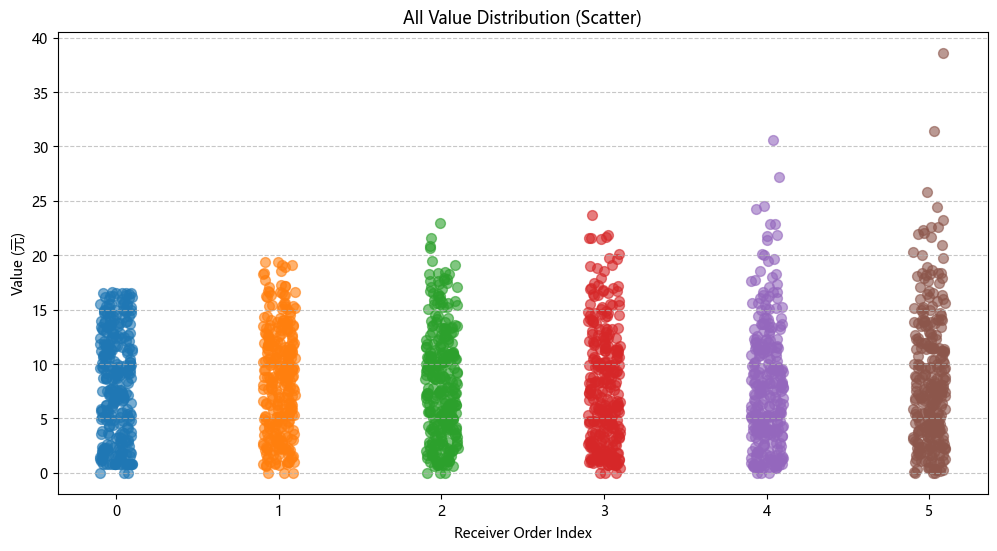

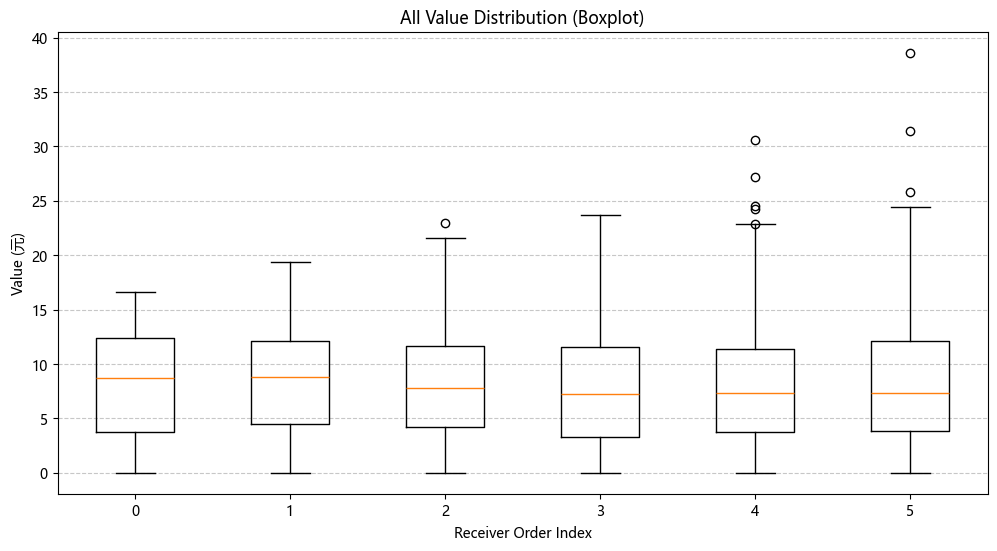

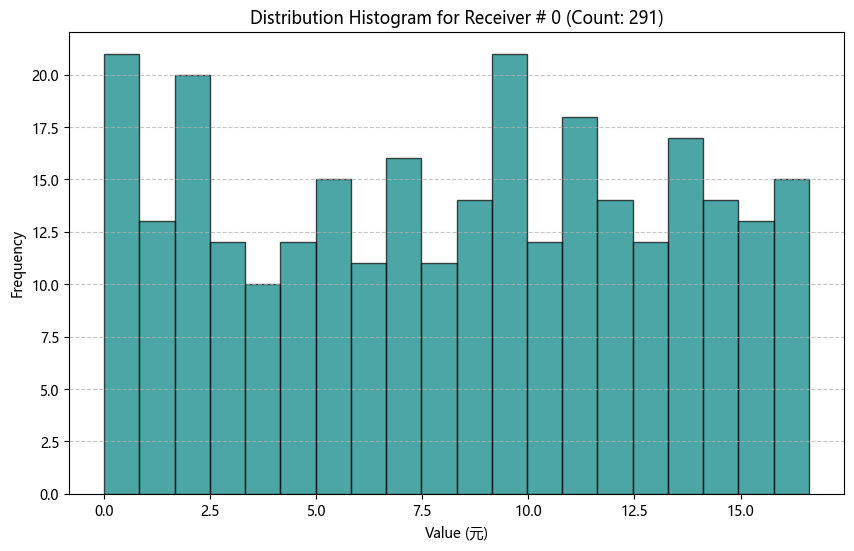

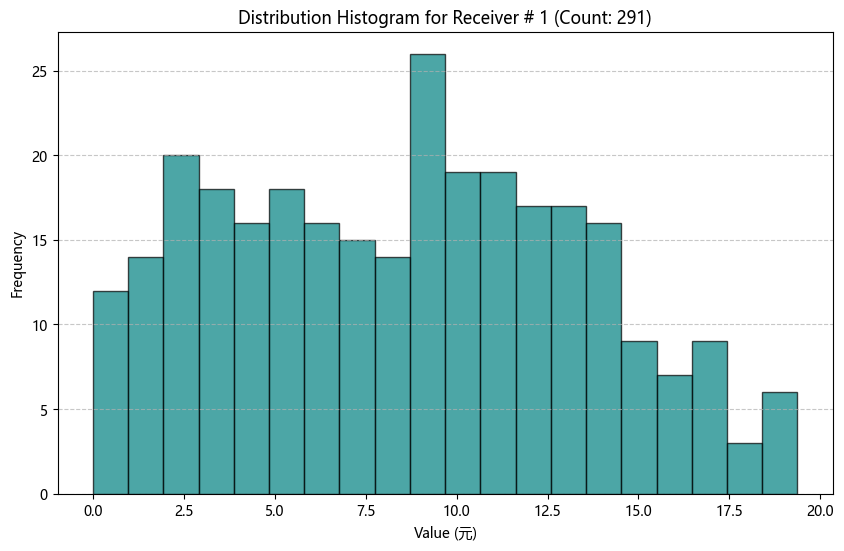

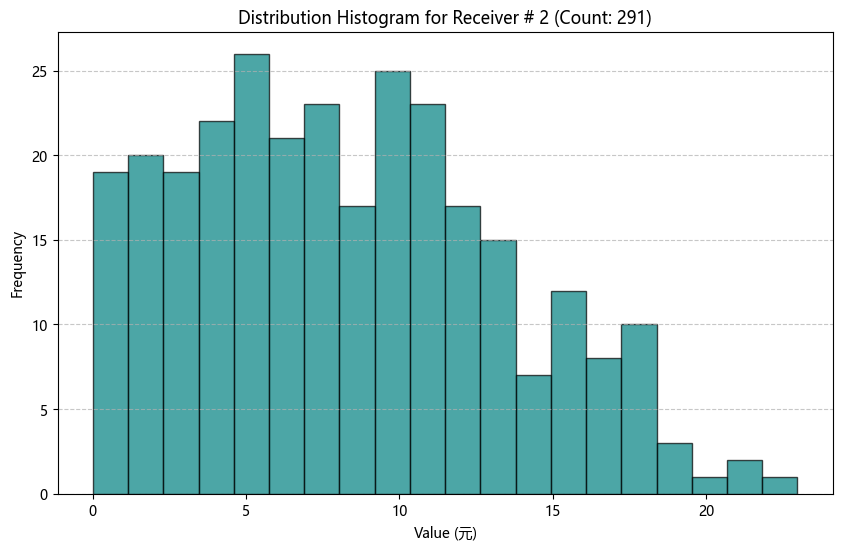

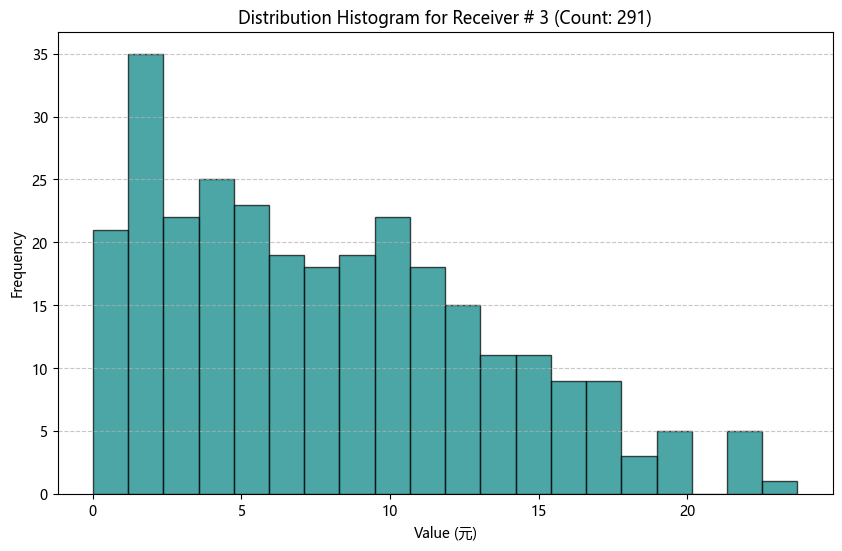

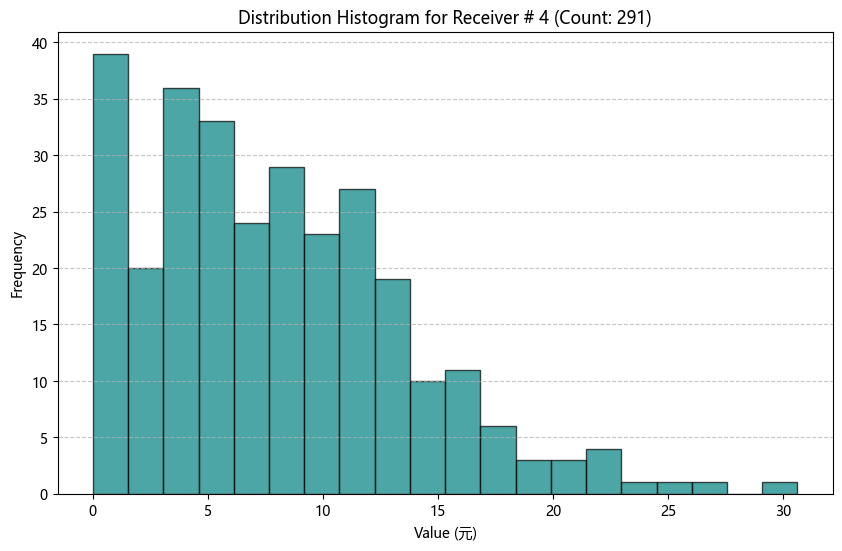

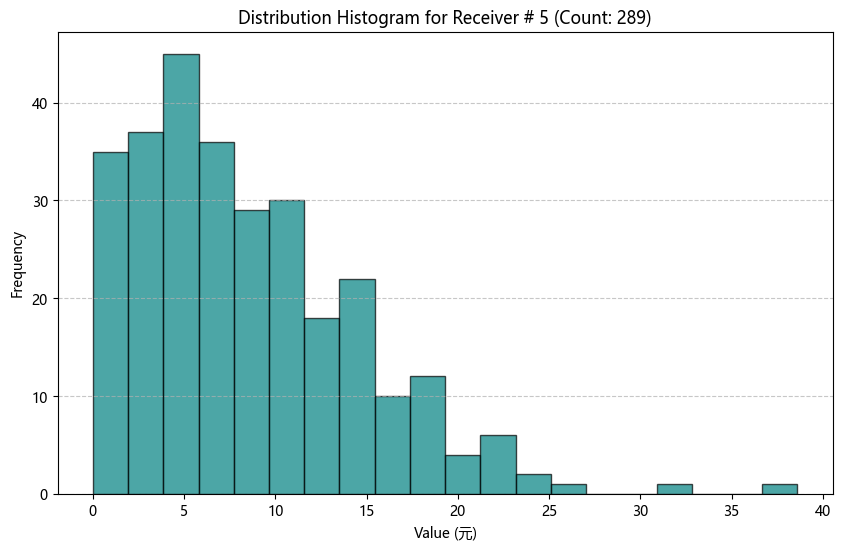

In [ ]:
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "DejaVu Sans"]

# import DataExtractor

OUTPUT_DIR = "Output/"
DATABASE_DIR = "ProcessedData/"  # Acknowledged and manually transferred long-term data storage from OUTPUT_DIR


def process_all_snapshots():
    # Cleanup: Delete all temp generated .jpgs in Snapshots/
    jpg_files = glob.glob(os.path.join("Snapshots", "*.jpg"))
    if jpg_files:
        print(f"Cleaning up {len(jpg_files)} .jpg files in Snapshots/...")
        for f in jpg_files:
            try:
                os.remove(f)
            except Exception as e:
                print(f"Failed to delete {f}: {e}")

    snapshot_files = glob.glob(os.path.join("Snapshots", "info*.png"))

    snapshot_files.sort()

    all_data = []

    print(f"Found {len(snapshot_files)} files: {snapshot_files}")

    for file_path in snapshot_files:
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue

        print(f"Processing {file_path}...")

        file_data = extract_data_from_image(file_path)

        if file_data:
            all_data.append(file_data)
            print(f"Extracted {len(file_data)} items from {file_path}")
        else:
            print(f"Failed to extract data from {file_path}")

    if not all_data:
        print("No data collected.")
        return

    print(f"Collected data groups: {len(all_data)}")

    # Save all_data to a JSON
    output_json_path = os.path.join(OUTPUT_DIR, "all_data.json")
    try:
        with open(output_json_path, "w", encoding="utf-8") as f:
            json.dump(all_data, f, ensure_ascii=False, indent=4)
        print(f"All data saved to {output_json_path}")
    except Exception as e:
        print(f"Error saving data to file: {e}")


def visualize_data(all_data):
    plt.figure(figsize=(12, 6))

    # Data logic for plotting
    # Example: all_data = [[A1, B1], [A2, B2], [A3, B3]]
    # Index 0 (A): Values (A1, A2, A3)
    # Index 1 (B): Values (B1, B2, B3)

    # Determine maximum dimension length
    max_len = max(len(d) for d in all_data) if all_data else 0

    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)

    # 1. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    # 1. Prepare data by dimension
    data_by_dimension = []
    for dim_idx in range(max_len):
        values = [snap[dim_idx] for snap in all_data if dim_idx < len(snap)]
        data_by_dimension.append(values)

    # 2. Overlay Plot: Vertical Scatter (Index vs Value)
    plt.figure(figsize=(12, 6))

    for dim_idx, values in enumerate(data_by_dimension):
        if values:
            # Add random jitter to x coordinates
            jitter = np.random.uniform(-0.1, 0.1, len(values))
            x = np.array([dim_idx] * len(values)) + jitter

            plt.scatter(
                x,
                values,
                alpha=0.6,
                s=50,
                label=f"Dim {dim_idx}" if dim_idx == 0 else "",
            )

    plt.title("All Value Distribution (Scatter)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.xticks(range(max_len))
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # all_plot_path = os.path.join(OUTPUT_DIR, "all_value_scatter.png")
    # plt.savefig(all_plot_path)
    # print(f"Combined plot saved to {all_plot_path}")
    plt.show()

    # 3. Overlay Plot: Vertical Boxplot (Index vs Value)
    plt.figure(figsize=(12, 6))
    plt.boxplot(data_by_dimension, tick_labels=range(max_len))

    plt.title("All Value Distribution (Boxplot)")
    plt.xlabel("Receiver Order Index")
    plt.ylabel("Value (元)")
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    # boxplot_path = os.path.join(OUTPUT_DIR, "all_value_boxplot.png")
    # plt.savefig(boxplot_path)
    # print(f"Boxplot saved to {boxplot_path}")
    plt.show()

    # 4. Individual Plots: Histogram (Value Distribution)

    # print("Generating individual histograms...")

    for dim_idx, values in enumerate(data_by_dimension):
        if not values:
            continue

        plt.figure(figsize=(10, 6))

        plt.hist(values, bins=20, color="teal", alpha=0.7, edgecolor="black")

        plt.title(
            f"Distribution Histogram for Receiver # {dim_idx} (Count: {len(values)})"
        )
        plt.xlabel("Value (元)")
        plt.ylabel("Frequency")
        plt.grid(axis="y", linestyle="--", alpha=0.7)

        # filename = os.path.join(OUTPUT_DIR, f"Receiver_Index_{dim_idx}_hist.png")
        # plt.savefig(filename)
        plt.show()

    # print(f"Individual histograms saved to {OUTPUT_DIR}")


# ====== Main Execution ======

# Load all_data.json if it exists, otherwise process snapshots
data_path = os.path.join(DATABASE_DIR, "all_data.json")

if os.path.exists(data_path):
    print(f"Loading data from {data_path}...")
    try:
        with open(data_path, "r", encoding="utf-8") as f:
            all_data = json.load(f)
        # print(f"Loaded {len(all_data)} data groups from {data_path}")
        visualize_data(all_data)
    except Exception as e:
        print(f"Error loading data from file: {e}")
        print("Falling back to processing snapshots...")
        process_all_snapshots()
else:
    process_all_snapshots()